Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


## Загрузка данных

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
# Работа с таблицами
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    SpatialDropout1D,
    BatchNormalization,
    Embedding,
    Flatten,
    Activation,
)

from tensorflow.keras.optimizers import Adam

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time

In [2]:
import gdown

# Скачивание файла
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)

'20writers.zip'

In [3]:
!unzip -qo 20writers.zip -d 20writers/
!ls 20writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [4]:
path = Path("20writers") # Указание пути к папке
text = []
class_names = []
# Проход по всем файлам/папкам внутри указанной директории
for f in path.iterdir():
    class_names.append(f.name)
    text.append(f.read_text().replace("\n", " "))

In [5]:
# Вычисление длины каждого текста в символах
text_lens = [len(t) for t in text]
split_indices = [int(lenth * 0.8) for lenth in text_lens]

# Вывод списка длин всех текстов
print(text_lens)

[2152214, 2523380, 2255254, 1965119, 1992830, 2952792, 6611627, 3408339, 2328900, 3104712, 5178950, 1980206, 969109, 3357061, 2399413, 2001064, 3386268, 1972541, 3089426, 2579246]


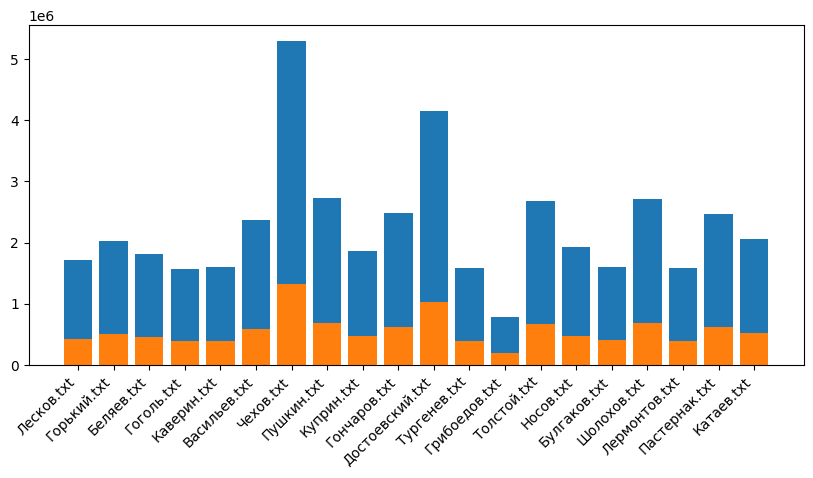

In [6]:
train_text = [] # Список для хранения обучающих фрагментов текстов
test_text = [] # Список для хранения тестовых (валидационных) фрагментов текстов

# Разделение каждого текста на обучающую и тестовую части
for i, t in enumerate(text):
    train_text.append(t[:split_indices[i]])
    test_text.append(t[split_indices[i]:])

# Проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
c_train = split_indices
c_test = [i-j for i, j in zip(text_lens, split_indices)]
plt.bar(class_names, c_train)
plt.bar(class_names, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()


In [7]:
VOCAB_SIZE = 25_000
WIN_SIZE = 4000
WIN_HOPE = 500

In [8]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)


In [9]:
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))


In [10]:
with timex():
    tokenizer = Tokenizer(
        num_words=VOCAB_SIZE,
        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
        lower=True,
        split=" ",
        oov_token="неизвестное_слово",
        char_level=False,
    )
    tokenizer.fit_on_texts(text)
    seq_train = tokenizer.texts_to_sequences(train_text)
    seq_test = tokenizer.texts_to_sequences(test_text)
    # Формирование обучающей и тестовой выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)


Время обработки: 27.99 с


In [11]:
# Замер времени преобразования обучающих последовательностей в матрицу признаков
with timex():
    x_train_matrix = tokenizer.sequences_to_matrix(x_train.tolist()).astype("float16")

# Замер времени преобразования тестовых (валидационных) последовательностей в матрицу признаков
with timex():
    x_test_matrix = tokenizer.sequences_to_matrix(x_test.tolist()).astype("float16")

Время обработки: 20.61 с
Время обработки: 4.51 с


In [12]:
# Преобразуем one-hot обратно в метки классов
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

In [13]:
# Подсчёт с помощью bincount
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Вывод результатов
print("Обучающая выборка:")
for cls, count in enumerate(train_counts):
    print(f"Класс {cls}: {count} окон")

print("\nТестовая выборка:")
for cls, count in enumerate(test_counts):
    print(f"Класс {cls}: {count} окон")


Обучающая выборка:
Класс 0: 537 окон
Класс 1: 647 окон
Класс 2: 532 окон
Класс 3: 479 окон
Класс 4: 479 окон
Класс 5: 706 окон
Класс 6: 1656 окон
Класс 7: 823 окон
Класс 8: 558 окон
Класс 9: 780 окон
Класс 10: 1294 окон
Класс 11: 484 окон
Класс 12: 239 окон
Класс 13: 829 окон
Класс 14: 586 окон
Класс 15: 470 окон
Класс 16: 791 окон
Класс 17: 488 окон
Класс 18: 726 окон
Класс 19: 602 окон

Тестовая выборка:
Класс 0: 121 окон
Класс 1: 153 окон
Класс 2: 127 окон
Класс 3: 115 окон
Класс 4: 115 окон
Класс 5: 169 окон
Класс 6: 422 окон
Класс 7: 194 окон
Класс 8: 134 окон
Класс 9: 188 окон
Класс 10: 327 окон
Класс 11: 116 окон
Класс 12: 52 окон
Класс 13: 206 окон
Класс 14: 150 окон
Класс 15: 111 окон
Класс 16: 201 окон
Класс 17: 117 окон
Класс 18: 171 окон
Класс 19: 143 окон


In [14]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Вычисление весов классов для компенсации дисбаланса классов в обучающей выборке
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1),
)
# Преобразование массива весов в словарь
class_weight_dict = dict(enumerate(class_weights))

In [15]:
# Создание модели
model = Sequential(
    [
        Input((VOCAB_SIZE,)),
        Dropout(0.6),
        Dense(64, activation="relu"),
        Dropout(0.6),
        Dense(20, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 25000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,600,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601,364 (6.11 MB)

 Trainable params: 1,601,364 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Обучение модели
history = model.fit(
    x_train_matrix,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test_matrix, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.2623 - loss: 2.4332 - val_accuracy: 0.9619 - val_loss: 0.5547
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8812 - loss: 0.4484 - val_accuracy: 0.9715 - val_loss: 0.2520
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9518 - loss: 0.2030 - val_accuracy: 0.9727 - val_loss: 0.1845
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9645 - loss: 0.1414 - val_accuracy: 0.9742 - val_loss: 0.1493
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9754 - loss: 0.1075 - val_accuracy: 0.9736 - val_loss: 0.1304
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9795 - loss: 0.0895 - val_accuracy: 0.9730 - val_loss: 0.1220
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9794 - loss: 0.0797 - val_accuracy: 0.9742 - val_loss: 0.1111
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9798 - loss: 0.0677 - val_accuracy: 0.9751 - 

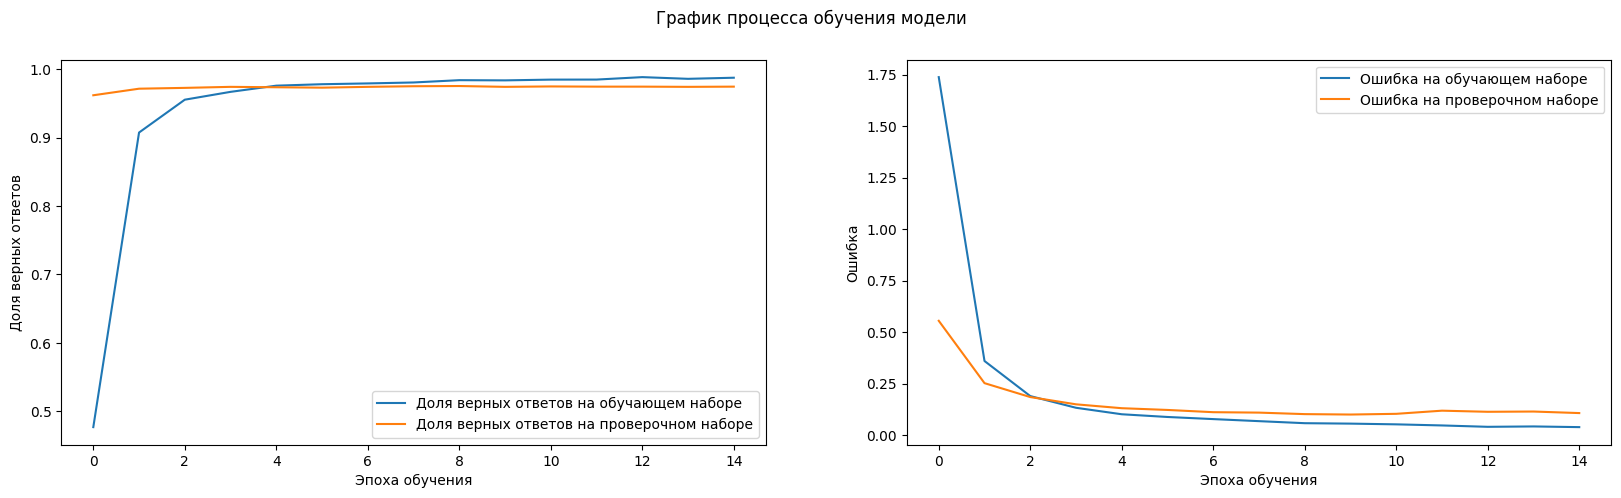

In [17]:
# Построение графиков процесса обучения модели
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели")
ax1.plot(history.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()


In [18]:
def eval_model(
    model, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


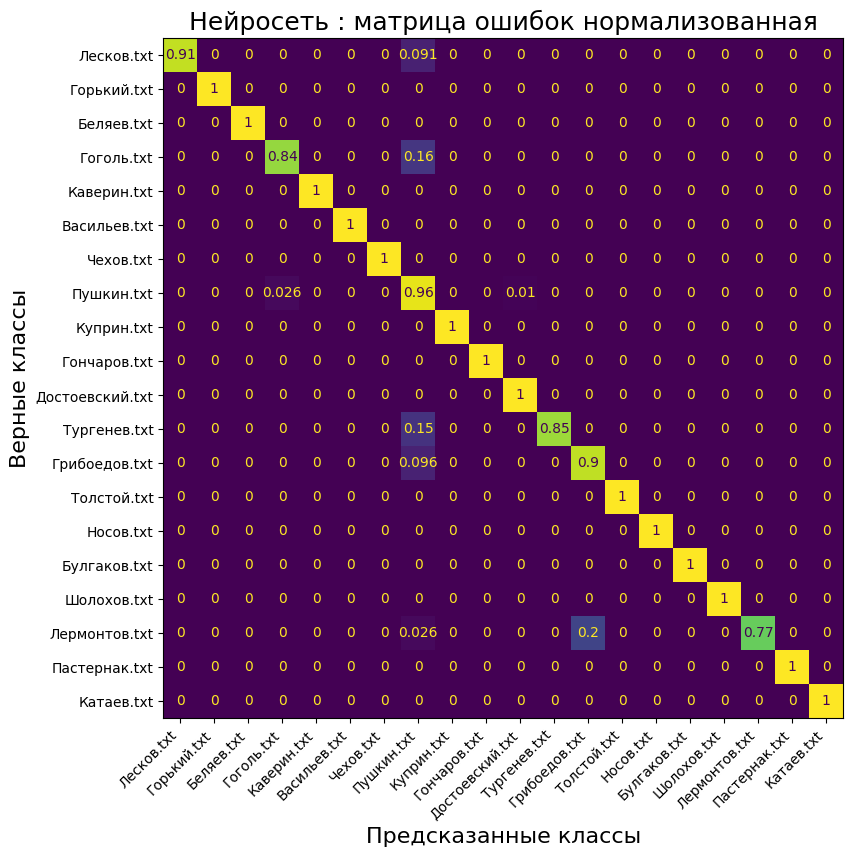

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Лесков.txt            91% сеть отнесла к классу Лесков.txt           - ВЕРНО :-)
Класс: Горький.txt          100% сеть отнесла к классу Горький.txt          - ВЕРНО :-)
Класс: Беляев.txt           100% сеть отнесла к классу Беляев.txt           - ВЕРНО :-)
Класс: Гоголь.txt            84% сеть отнесла к классу Гоголь.txt           - ВЕРНО :-)
Класс: Каверин.txt          100% сеть отнесла к классу Каверин.txt          - ВЕРНО :-)
Класс: Васильев.txt         100% сеть отнесла к классу Васильев.txt         - ВЕРНО :-)
Класс: Чехов.txt            100% сеть отнесла к классу Чехов.txt            - ВЕРНО :-)
Класс: Пушкин.txt            96% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Куприн.txt           100% сеть отнесла к классу Куприн.txt           - ВЕРНО :-)
Класс: Гончаров.txt         100% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: 

In [19]:
eval_model(model, x_test_matrix, y_test, class_names)

In [20]:
# Создание модели
model_emb = Sequential(
    [
        Embedding(VOCAB_SIZE, 400, input_length=WIN_SIZE),
        SpatialDropout1D(0.4),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(20, activation="softmax"),
    ]
)
model_emb.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_emb.build(input_shape=(None, WIN_SIZE))
model_emb.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 4000, 400)      │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 4000, 400)      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │   102,400,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,401,364 (428.78 MB)

 Trainable params: 112,401,364 (428.78 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history_emb = model_emb.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 317ms/step - accuracy: 0.1168 - loss: 2.8283 - val_accuracy: 0.4622 - val_loss: 1.8850
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.8684 - loss: 0.4831 - val_accuracy: 0.7773 - val_loss: 0.9205
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9907 - loss: 0.0613 - val_accuracy: 0.7992 - val_loss: 0.7741
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9952 - loss: 0.0326 - val_accuracy: 0.8166 - val_loss: 0.7079
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9971 - loss: 0.0207 - val_accuracy: 0.8076 - val_loss: 0.6795
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9982 - loss: 0.0157 - val_accuracy: 0.8124 - val_loss: 0.6565
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9985 - loss: 0.0116 - val_accuracy: 0.8148 - val_loss: 0.6413
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.9987 - loss: 0.0100 - val_accuracy: 

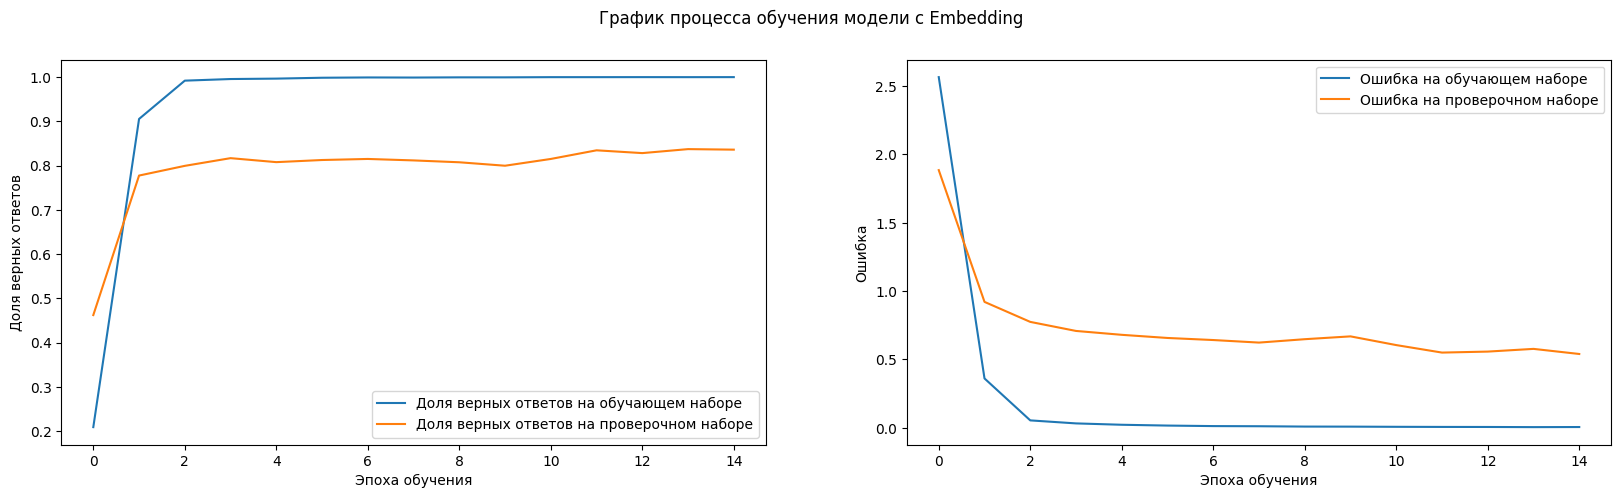

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели с Embedding")
ax1.plot(history_emb.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history_emb.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history_emb.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history_emb.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


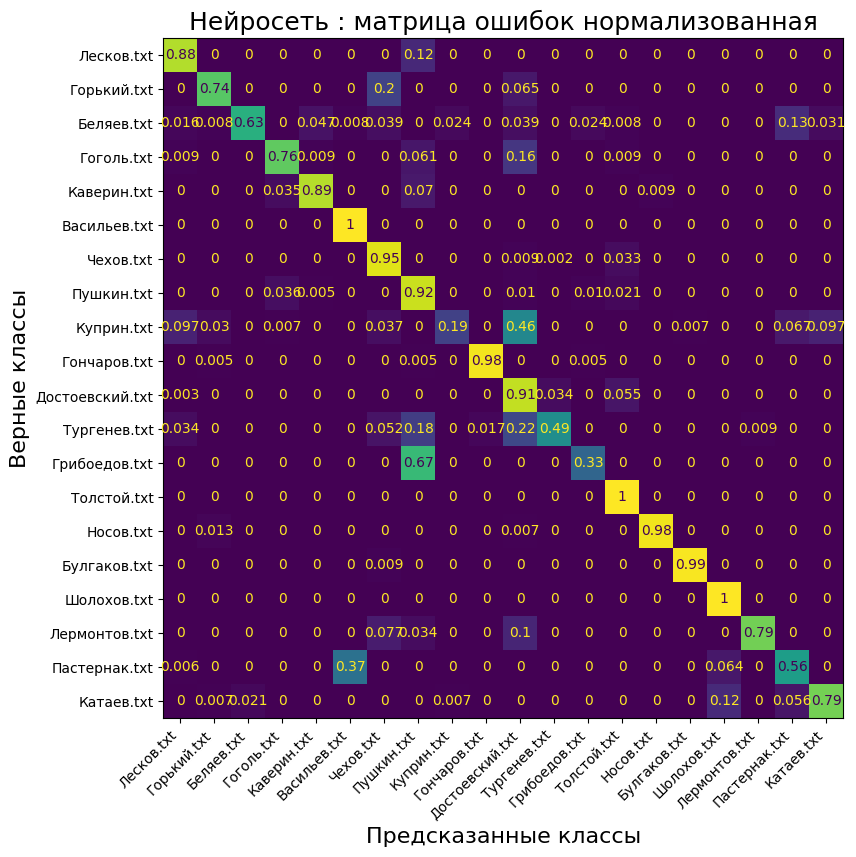

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Лесков.txt            88% сеть отнесла к классу Лесков.txt           - ВЕРНО :-)
Класс: Горький.txt           74% сеть отнесла к классу Горький.txt          - ВЕРНО :-)
Класс: Беляев.txt            63% сеть отнесла к классу Беляев.txt           - ВЕРНО :-)
Класс: Гоголь.txt            76% сеть отнесла к классу Гоголь.txt           - ВЕРНО :-)
Класс: Каверин.txt           89% сеть отнесла к классу Каверин.txt          - ВЕРНО :-)
Класс: Васильев.txt         100% сеть отнесла к классу Васильев.txt         - ВЕРНО :-)
Класс: Чехов.txt             96% сеть отнесла к классу Чехов.txt            - ВЕРНО :-)
Класс: Пушкин.txt            92% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Куприн.txt            46% сеть отнесла к классу Достоевский.txt      - НЕВЕРНО :-(
Класс: Гончаров.txt          98% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс

In [23]:
eval_model(model_emb, x_test, y_test, class_names)